In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function, division
import pandas
import src
import os, os.path
import matplotlib.pyplot as plt
from operator import itemgetter

In [3]:
def fake(*args, **kwargs):
    print('Fake called with', str(args), str(kwargs))
    sys.exit(1)

# fake out the create_model so we don't accidentally attempt to create data
src.common.create_model = fake

print(os.getcwd())
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
print(os.getcwd())

/home/cscorley/git/triage/notebooks
/home/cscorley/git/triage


In [4]:
def best_pair(s, t):
    s = reversed(sorted(enumerate(s), key=itemgetter(1)))
    t = reversed(sorted(enumerate(t), key=itemgetter(1)))
    for (i, item_i), (j, item_j) in zip(s, t):
        if i == j:
            return i

In [5]:
projects = src.common.load_projects(dict(level='file'))
projects

[Project(name='tika', printable_name='Tika v1.8', version='v1.8', ref='refs/tags/1.8', data_path='data/tika/', full_path='data/tika/v1.8/', src_path='data/tika/v1.8/src/', level='file'),
 Project(name='pig', printable_name='Pig v0.14.0', version='v0.14.0', ref='refs/tags/release-0.14.0', data_path='data/pig/', full_path='data/pig/v0.14.0/', src_path='data/pig/v0.14.0/src/', level='file'),
 Project(name='bookkeeper', printable_name='BookKeeper v4.3.0', version='v4.3.0', ref='refs/tags/release-4.3.0', data_path='data/bookkeeper/', full_path='data/bookkeeper/v4.3.0/', src_path='data/bookkeeper/v4.3.0/src/', level='file'),
 Project(name='openjpa', printable_name='OpenJPA v2.3.0', version='v2.3.0', ref='refs/tags/2.3.0', data_path='data/openjpa/', full_path='data/openjpa/v2.3.0/', src_path='data/openjpa/v2.3.0/src/', level='file'),
 Project(name='mahout', printable_name='Mahout v0.10.0', version='v0.10.0', ref='refs/tags/mahout-0.10', data_path='data/mahout/', full_path='data/mahout/v0.10.0

In [6]:
names = {'model': {'score': 'score',
                   'model_base_alpha': 'alpha',
                   'model_base_eta': 'eta',
                   'num_topics': 'K'
                  },
         'corpus': {'score': 'score',
                    'changeset_include_additions': 'Additions',
                    'changeset_include_context': 'Context',
                    'changeset_include_message': 'Message',
                    'changeset_include_removals': 'Removals',
                    },
        }
exps = ['triage', 'feature_location']
table_headers = {
    'model': ['K', 'alpha', 'eta', 'Feature Location', 'Triage'],
    'corpus': ['Additions', 'Removals', 'Context', 'Message', 'Feature Location', 'Triage']
}
formatters = {
    'Feature Location': lambda x: r"$\bm{%.4f}$" % x if x == max(main_df["Feature Location"]) else "$%.4f$" % x,
    'alpha': lambda x: "$%s/K$" % x if x != 'auto' else x,
    'eta': lambda x: "$%s/K$" % x if x != 'auto' else x,
    'K': lambda x: "$%s$" % x,
    'Triage': lambda x:  r"$\bm{%.4f}$" % x if x == max(main_df["Triage"]) else "$%.4f$" % x,
}

full_tex = r"""
\begin{table}
\begin{spacing}{1.2}
\centering
\caption{MRR values of %s %s construction sweep}
\label{table:%s}
\vspace{0.2em}
%s
\end{spacing}
\end{table}
"""

best_flt = list()
best_dit = list()
tex_dir = os.path.expanduser("~/git/dissertation/tables")
for project in projects:
    for rq in names.keys():
        names[rq]['score'] = 'score'
        main_df = pandas.DataFrame(columns=names[rq])
        for exp in exps:
            path = os.path.join(project.full_path, 'optimized-%s-changeset-%s.csv' % (rq, exp))
            exp = ' '.join(exp.title().split('_'))
            names[rq]['score'] = exp
            exp_df = pandas.read_csv(path)
            exp_df = exp_df.rename(columns=names[rq])
            if len(main_df):
                main_df = main_df.merge(exp_df)
            else:
                main_df = exp_df
        
        # filter out uninteresting rows, like there was no corpus
        main_df = main_df[(main_df["Feature Location"] != 0) | (main_df["Triage"] != 0)]
        if rq == "model":
            main_df = main_df.sort(["K", "alpha", "eta"])
        else:
            main_df = main_df.sort(["Additions", "Removals", "Context", "Message"], ascending=False)
        
        best_flt.append((project, main_df[main_df["Feature Location"] == main_df["Feature Location"].max()]))
        best_dit.append((project, main_df[main_df["Triage"] == main_df["Triage"].max()]))
        
        label = "%s_%s_sweep" % (project.name, rq)
        op = os.path.join(tex_dir, label + ".tex")
        
        if len(main_df) > 24:
            tex = r"\parbox{.45\linewidth}{\centering %s} \hfill \parbox{.45\linewidth}{\centering %s}"
            mid = len(main_df)//2
            tex = tex % (main_df[:mid].to_latex(index=False,
                                                escape=False, # needed so it doesn't screw up formatters
                                                formatters=formatters,
                                                columns=table_headers[rq]),
                         main_df[mid:].to_latex(index=False,
                                                escape=False, # needed so it doesn't screw up formatters
                                                formatters=formatters,
                                                columns=table_headers[rq]))
        else:
            tex = main_df.to_latex(index=False,
                                   escape=False, # needed so it doesn't screw up formatters
                                   formatters=formatters,
                                   columns=table_headers[rq],)
            
        #print(best_pair(main_df["Triage"], main_df["Feature Location"]))
        
        # and now the lazy
        this_full_tex = full_tex % (project.printable_name, rq, label, tex)
        this_full_tex = this_full_tex.replace(" alpha ", r" $\alpha$ ")
        this_full_tex = this_full_tex.replace(" eta ", r" $\eta$ ")
        this_full_tex = this_full_tex.replace(" Feature Location ", " FLT ")
        this_full_tex = this_full_tex.replace(" Triage ", " DIT ")
        this_full_tex = this_full_tex.replace(r"\begin{tabular}{rllrr}", r"\begin{tabular}{rll|rr}")
        this_full_tex = this_full_tex.replace(r"\begin{tabular}{llllrr}", r"\begin{tabular}{llll|rr}")
        print("Writing to: %s\n%s\n" % (op, this_full_tex))
        with open(op, 'wt') as f:
            f.write(this_full_tex)

None
Writing to: /home/cscorley/git/dissertation/tables/tika_model_sweep.tex

\begin{table}
\begin{spacing}{1.2}
\centering
\caption{MRR values of Tika v1.8 model construction sweep}
\label{table:tika_model_sweep}
\vspace{0.2em}
\parbox{.45\linewidth}{\centering \begin{tabular}{rll|rr}
\toprule
    K &  $\alpha$ &    $\eta$ & FLT &   DIT \\
\midrule
$100$ &  $1/K$ &  $1/K$ &         $0.3030$ & $0.2813$ \\
$100$ &  $1/K$ &  $2/K$ &         $0.3104$ & $0.2858$ \\
$100$ &  $1/K$ &  $5/K$ &         $0.3377$ & $0.2377$ \\
$100$ &  $1/K$ &   auto &         $0.2793$ & $0.2814$ \\
$100$ &  $2/K$ &  $1/K$ &         $0.3013$ & $0.2732$ \\
$100$ &  $2/K$ &  $2/K$ &         $0.3007$ & $0.2609$ \\
$100$ &  $2/K$ &  $5/K$ &         $0.3418$ & $0.2410$ \\
$100$ &  $2/K$ &   auto &         $0.2782$ & $0.2881$ \\
$100$ &  $5/K$ &  $1/K$ &         $0.3199$ & $0.2898$ \\
$100$ &  $5/K$ &  $2/K$ &         $0.3396$ & $0.2799$ \\
$100$ &  $5/K$ &  $5/K$ &         $0.3273$ & $0.2223$ \\
$100$ &  $5/K$ &   au

In [7]:
best_flt_model = {p:x for p,x in best_flt if hasattr(x, 'alpha')}
best_flt_corpus = {p:x for p,x in best_flt if hasattr(x, 'Additions')}
best_dit_model = {p:x for p,x in best_dit if hasattr(x, 'alpha')}
best_dit_corpus = {p:x for p,x in best_dit if hasattr(x, 'Additions')}

In [8]:
best_dit_corpus

{Project(name='bookkeeper', printable_name='BookKeeper v4.3.0', version='v4.3.0', ref='refs/tags/release-4.3.0', data_path='data/bookkeeper/', full_path='data/bookkeeper/v4.3.0/', src_path='data/bookkeeper/v4.3.0/src/', level='file'):      Triage Additions Context Message Removals  Feature Location
 0  0.721646      True    True    True     True            0.5246,
 Project(name='mahout', printable_name='Mahout v0.10.0', version='v0.10.0', ref='refs/tags/mahout-0.10', data_path='data/mahout/', full_path='data/mahout/v0.10.0/', src_path='data/mahout/v0.10.0/src/', level='file'):      Triage Additions Context Message Removals  Feature Location
 7  0.382731      True   False   False    False          0.260056,
 Project(name='openjpa', printable_name='OpenJPA v2.3.0', version='v2.3.0', ref='refs/tags/2.3.0', data_path='data/openjpa/', full_path='data/openjpa/v2.3.0/', src_path='data/openjpa/v2.3.0/src/', level='file'):      Triage Additions Context Message Removals  Feature Location
 5  0.4

In [9]:
kwargs = dict(model='lda', level='file', source=['changeset'], force=False)

def get_model_config(table, project):
    model_config, model_config_string = src.main.get_default_model_config(kwargs)
    changeset_config, changeset_config_string = src.main.get_default_changeset_config()
    
    K = int(table[project]['K'].values[0])
    alpha = table[project]['alpha'].values[0]
    eta = table[project]['eta'].values[0]
    model_config['alpha'] =  int(alpha) / K if alpha != 'auto' else alpha
    model_config['eta'] = int(eta) / K if eta != 'auto' else eta
    model_config['num_topics'] = K

    model_config_string =  '-'.join([unicode(v) for k, v in sorted(model_config.items())])
    changeset_config_string = '-'.join([unicode(v) for k, v in sorted(changeset_config.items())])

    kwargs.update({'changeset_config': changeset_config,
                   'changeset_config_string': changeset_config_string})

    kwargs.update({'model_config': model_config,
                   'model_config_string': model_config_string})
    
    return [x for x in src.common.load_projects(kwargs) if x.name == project.name][0]

def get_corpus_config(table, project):
    model_config, model_config_string = src.main.get_default_model_config(kwargs)
    changeset_config, changeset_config_string = src.main.get_default_changeset_config()
    
    changeset_config['include_additions'] = table[project]['Additions'].values[0]
    changeset_config['include_removals'] = table[project]['Removals'].values[0]
    changeset_config['include_context'] = table[project]['Context'].values[0]
    changeset_config['include_message'] = table[project]['Message'].values[0]

    model_config_string =  '-'.join([unicode(v) for k, v in sorted(model_config.items())])
    changeset_config_string = '-'.join([unicode(v) for k, v in sorted(changeset_config.items())])

    kwargs.update({'changeset_config': changeset_config,
                   'changeset_config_string': changeset_config_string})

    kwargs.update({'model_config': model_config,
                   'model_config_string': model_config_string})
    
    return [x for x in src.common.load_projects(kwargs) if x.name == project.name][0]

In [10]:
best_model_flt_projects = list()
best_model_dit_projects = list()
best_corpus_flt_projects = list()
best_corpus_dit_projects = list()
for project in projects:
    # load project info
    best_model_flt_projects.append(get_model_config(best_flt_model, project))
    best_model_dit_projects.append(get_model_config(best_dit_model, project))
    
    best_corpus_flt_projects.append(get_corpus_config(best_flt_corpus, project))
    best_corpus_dit_projects.append(get_corpus_config(best_dit_corpus, project))

In [11]:
print("best dit corpus")
for each in best_corpus_dit_projects:
    print(each.printable_name, src.common.check_ranks(each, "changeset", "triage")[1])

print()
print("best flt corpus")
for each in best_corpus_flt_projects:
    print(each.printable_name, src.common.check_ranks(each, "changeset", "feature_location")[1])

print()
print("best dit model")
for each in best_model_dit_projects:
    print(each.printable_name, src.common.check_ranks(each, "changeset", "triage")[1])

print()
print("best flt model")
for each in best_model_flt_projects:
    print(each.printable_name, src.common.check_ranks(each, "changeset", "feature_location")[1])

best dit corpus
Tika v1.8 changeset-triage-lda-true-true-false-false-batch-0.002-0.5-0.002-1000-1000-500-1.0-1
Pig v0.14.0 changeset-triage-lda-false-true-false-false-batch-0.002-0.5-0.002-1000-1000-500-1.0-1
BookKeeper v4.3.0 changeset-triage-lda-true-true-true-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1
OpenJPA v2.3.0 changeset-triage-lda-true-true-false-false-batch-0.002-0.5-0.002-1000-1000-500-1.0-1
Mahout v0.10.0 changeset-triage-lda-true-false-false-false-batch-0.002-0.5-0.002-1000-1000-500-1.0-1
ZooKeeper v3.5.0 changeset-triage-lda-false-true-false-false-batch-0.002-0.5-0.002-1000-1000-500-1.0-1

best flt corpus
Tika v1.8 changeset-feature_location-lda-true-true-true-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1
Pig v0.14.0 changeset-feature_location-lda-true-false-false-true-batch-0.002-0.5-0.002-1000-1000-500-1.0-1
BookKeeper v4.3.0 changeset-feature_location-lda-true-true-true-false-batch-0.002-0.5-0.002-1000-1000-500-1.0-1
OpenJPA v2.3.0 changeset-feature_location-lda-t

In [26]:
FIG_TEX="""
\\begin{figure}
\\centering
\\includegraphics[height=0.4\\textheight]{%s}
\\caption{%s effectiveness measures of optimal and alternative %s configurations for %s}
\\label{fig:combo:%s}
\\end{figure}
"""

FIG_TEX="""
\\begin{figure}
    \\centering
    \\begin{subfigure}{.4\\textwidth}
        \\centering
        \\includegraphics[height=0.4\\textheight]{%s}
        \\caption{Including outliers}\\label{fig:combo:%s_outlier}
    \\end{subfigure}%%
    \\begin{subfigure}{.4\\textwidth}
        \\centering
        \\includegraphics[height=0.4\\textheight]{%s_no_outlier}
        \\caption{Excluding outliers}\\label{fig:combo:%s_no_outlier}
    \\end{subfigure}
\\caption{%s effectiveness measures of optimal and alternative %s configurations for %s}
\\label{fig:combo:%s}
\\end{figure}
"""

def plot_panel(panel, name, kind):
    order = ["Optimal", "Alternate"]
    
    size = (len(order)*1.6, 4.5)
    limitgrowth = 0.5
    fontsize = None
    widths = 0.3
    lower = 0
    kinds = {"flt": "Feature Location", "dit": "Developer Identification"}
    rqs = {"flt": {"rq1": "\\cone", "rq2": "\\ctwo", "all": "Overview"},
           "dit": {"rq1": "\\cone", "rq2": "\\ctwo", "all": "Overview"}}
    config_name = "model" if name == "rq1" else "corpus"

    allt = pandas.DataFrame()
    for each in panel:
        allt = allt.append(panel[each], ignore_index=True)

        upper = panel[each][order].max().max()+1
        result = panel[each].plot(kind='box',
                         fontsize=fontsize,
                         figsize=size,
                         widths=widths,
                         y=order)
        limit = result.get_ylim()
        lower = limit[0] - limitgrowth
        if (lower < 0):
            lower = 0
        result.set_ylim(lower, limit[1] + limitgrowth)
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        short_each = each.lower().split(' ')[0]
        fig_name = 'figures/combo/%s_%s_%s' % (kind, name, short_each)
        path = os.path.expanduser('~/git/dissertation/') + fig_name
        plt.savefig(path + ".pdf", dpi=300)
        
        with open(path + ".tex", "wt") as f:
            figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
            f.write(FIG_TEX % (fig_name, figlabel, fig_name, figlabel, kinds[kind], config_name, each, figlabel))
            
        result = panel[each].plot(kind='box',
             fontsize=fontsize,
             figsize=size,
             widths=widths,
             y=order,
             showfliers=False)
        limit = result.get_ylim()
        lower = limit[0] - limitgrowth
        if (lower < 0):
            lower = 0
        result.set_ylim(lower, limit[1] + limitgrowth)
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        short_each = each.lower().split(' ')[0]
        fig_name = 'figures/combo/%s_%s_%s_no_outlier' % (kind, name, short_each)
        path = os.path.expanduser('~/git/dissertation/') + fig_name
        plt.savefig(path + ".pdf", dpi=300)
        
    upper = allt.max().max()+1
    allt.plot(kind='box', figsize=(4,1.5), grid=False, vert=False, y=list(reversed(order)))
    plt.tight_layout()
    short_each = "tiny"
    fig_name = 'figures/combo/%s_%s_%s' % (kind, name, short_each)
    path = os.path.expanduser('~/git/dissertation/') + fig_name
    plt.savefig(path + ".pdf", dpi=300)

    with open(path + ".tex", "wt") as f:
        figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
        f.write(FIG_TEX % (fig_name,  figlabel, fig_name, figlabel, kinds[kind], config_name, "all subject systems", figlabel))
    
    result = allt.plot(kind='box',
              fontsize=fontsize,
              figsize=size,
              widths=widths,
              ylim=(lower, upper),
              y=order)
    limit = result.get_ylim()
    lower = limit[0] - limitgrowth
    if (lower < 0):
        lower = 0
    result.set_ylim(lower, limit[1] + limitgrowth)
    #plt.gca().invert_yaxis()
    plt.tight_layout()
    short_each = "overview"
    fig_name = 'figures/combo/%s_%s_%s' % (kind, name, short_each)
    path = os.path.expanduser('~/git/dissertation/') + fig_name
    plt.savefig(path + ".pdf", dpi=300)
    with open(path + ".tex", "wt") as f:
        figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
        f.write(FIG_TEX % (fig_name,  figlabel, fig_name, figlabel,  kinds[kind], config_name, "all subject systems", figlabel))
        
    result = allt.plot(kind='box',
              fontsize=fontsize,
              figsize=size,
              widths=widths,
#              ylim=(lower, upper),
              y=order,
             showfliers=False)
    limit = result.get_ylim()
    lower = limit[0] - limitgrowth
    if (lower < 0):
        lower = 0
    result.set_ylim(lower, limit[1] + limitgrowth)
    #plt.gca().invert_yaxis()
    plt.tight_layout()
    short_each = "overview"
    fig_name = 'figures/combo/%s_%s_%s_no_outlier' % (kind, name, short_each)
    path = os.path.expanduser('~/git/dissertation/') + fig_name
    plt.savefig(path + ".pdf", dpi=300)

In [27]:
def generate_plots(question, best_dit, best_flt):
    flt_data_ranks = dict()
    for each in best_dit:
        flt_data_ranks[each.printable_name] = dict()
    dit_data_ranks = dict()
    for each in best_dit:
        dit_data_ranks[each.printable_name] = dict()


    for each in best_dit:
        dit_results = src.triage.run_experiment(each)['changeset']
        dit_data_ranks[each.printable_name]["Optimal"] = pandas.Series([int(x) for x,_,_ in dit_results])

        flt_results = src.feature_location.run_experiment(each)['changeset']
        flt_data_ranks[each.printable_name]["Alternate"] = pandas.Series([int(x) for x,_,_ in flt_results])

    for each in best_flt:
        dit_results = src.triage.run_experiment(each)['changeset']
        dit_data_ranks[each.printable_name]["Alternate"] = pandas.Series([int(x) for x,_,_ in dit_results])

        flt_results = src.feature_location.run_experiment(each)['changeset']
        flt_data_ranks[each.printable_name]["Optimal"] = pandas.Series([int(x) for x,_,_ in flt_results])

    dit_panel = pandas.Panel(dit_data_ranks)
    flt_panel = pandas.Panel(flt_data_ranks)
    plot_panel(dit_panel, question, "dit")
    plot_panel(flt_panel, question, "flt")

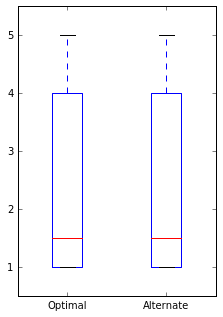

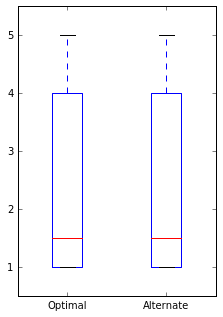

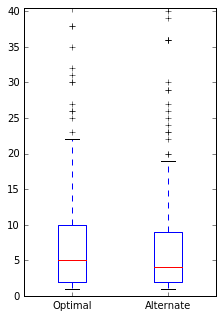

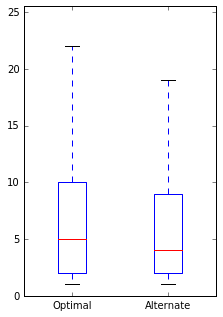

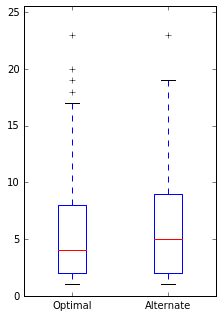

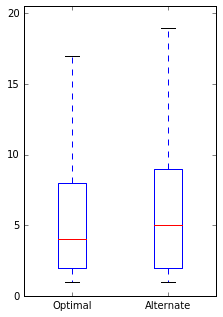

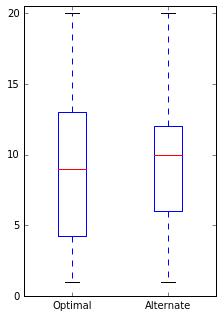

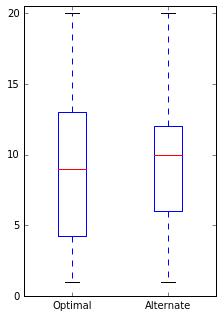

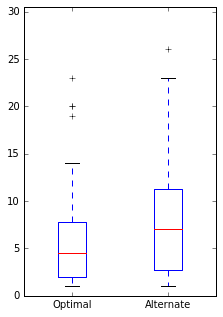

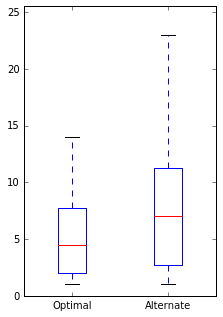

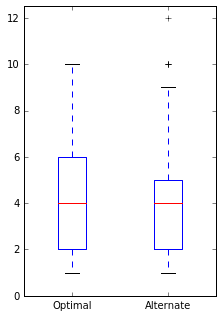

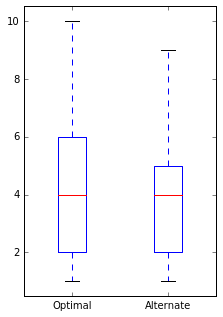

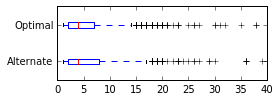

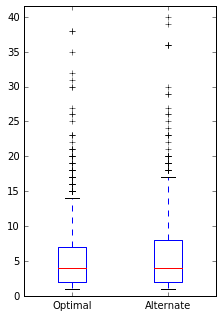

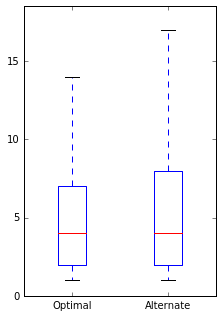

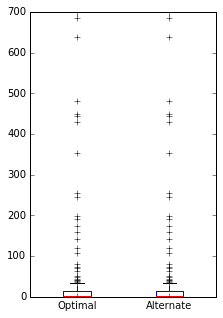

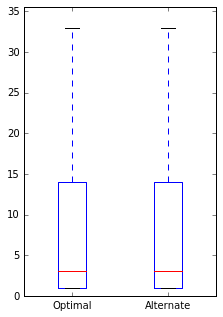

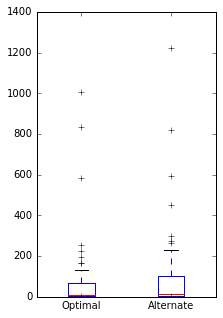

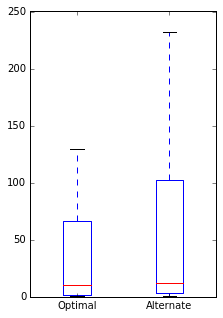

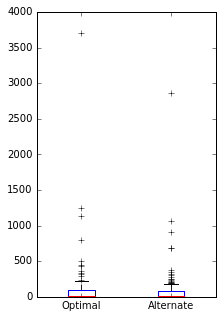

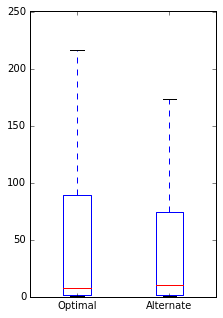

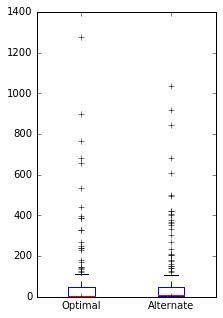

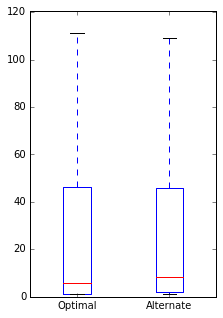

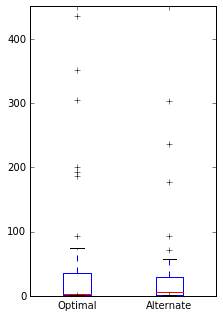

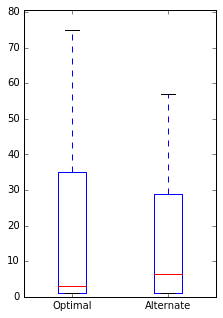

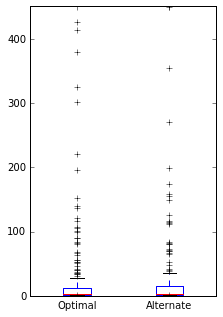

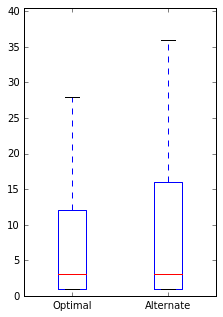

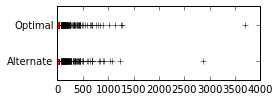

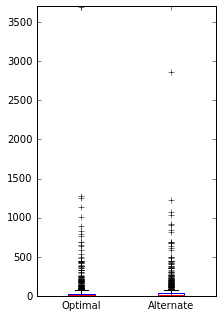

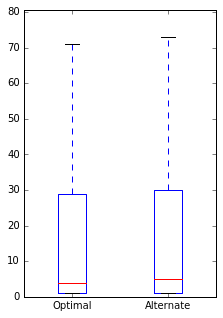

In [28]:
generate_plots("rq1", best_model_dit_projects, best_model_flt_projects)

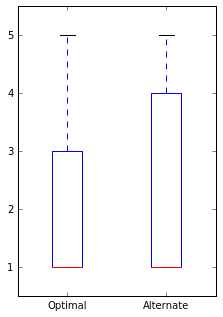

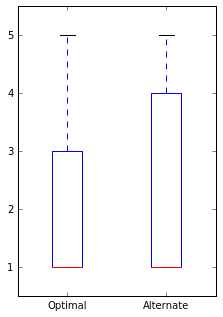

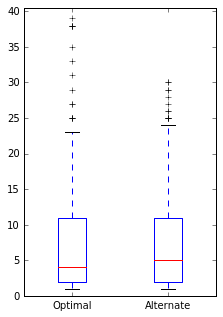

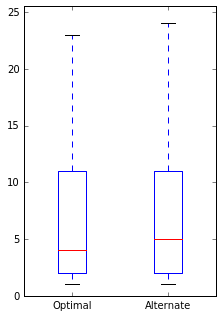

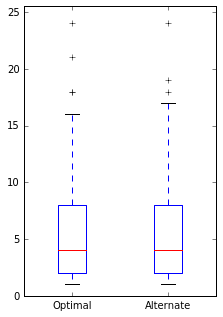

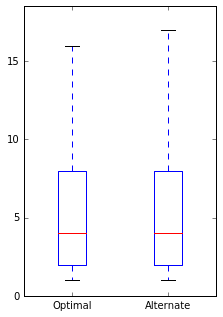

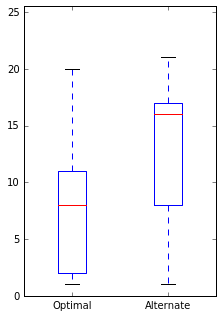

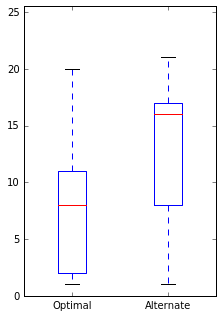

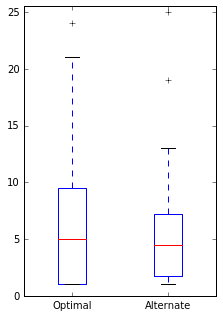

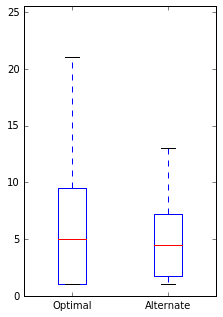

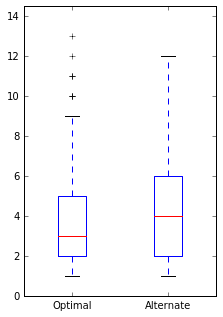

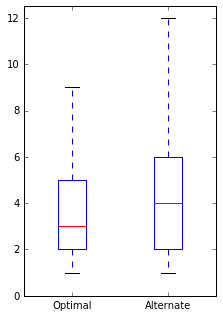

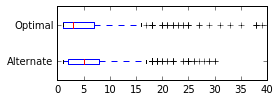

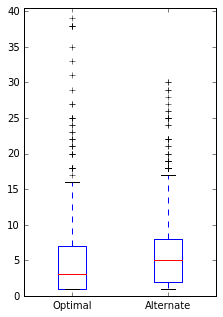

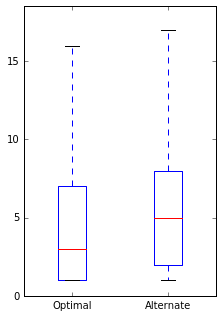

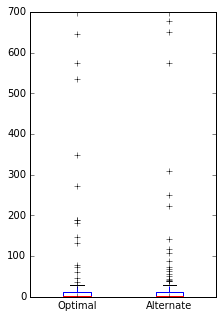

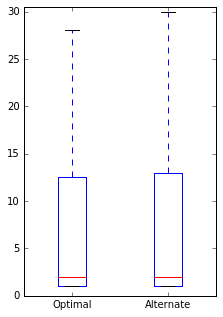

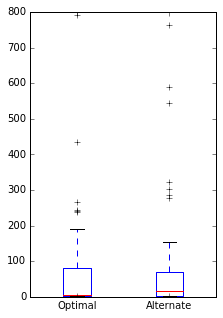

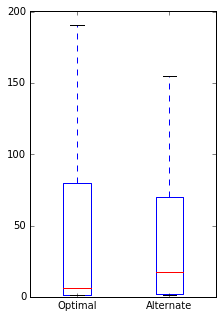

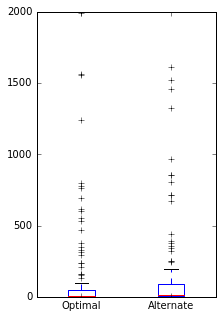

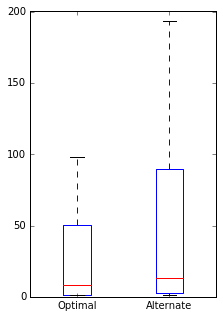

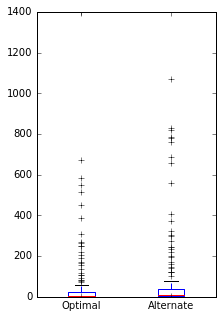

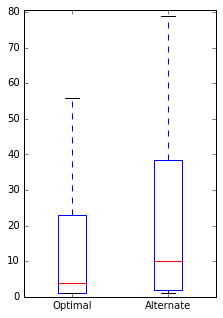

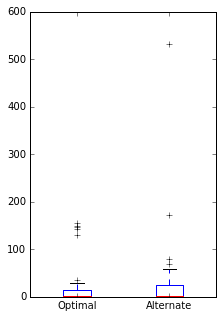

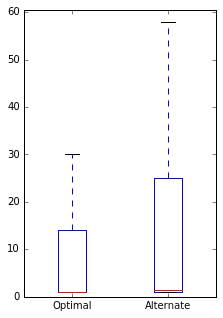

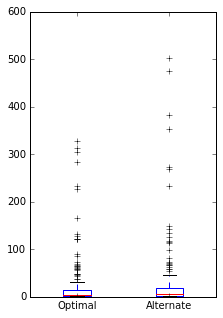

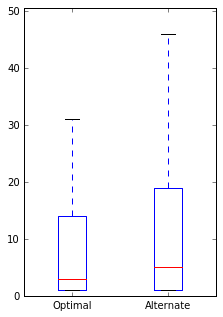

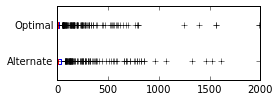

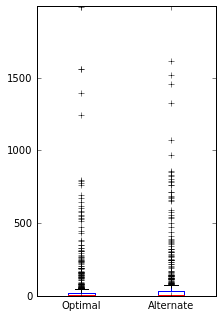

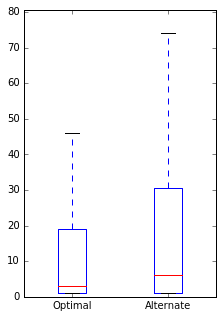

In [29]:
generate_plots("rq2", best_corpus_dit_projects, best_corpus_flt_projects)

In [33]:
allt

NameError: name 'allt' is not defined